# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

43600


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load summarized RNAseq for imaged loci


 Data can be generated by the notebook:

 [0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci](../0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci.ipynb)

In [8]:
import tqdm

rna_summary_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v1\AB_compartment\analysis'

sel_class_list =celltype_palette.keys()


ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(rna_summary_folder,f'subclass_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 199.64it/s]


In [9]:
rna_atac_df

,Unnamed: 0,mean_rna_2X_2000kb,mean_rna_2X_200kb,mean_rna_2X_50kb
loci_name,,,,
chr1_3742742_3759944,0,14.736264,12.552198,0.000000
chr1_6245958_6258969,1,5.254579,1.544872,1.544872
chr1_8740008_8759916,2,28.511905,0.000000,0.000000
chr1_9627926_9637875,3,33.426740,0.657509,0.000000
chr1_9799472_9811359,4,33.426740,0.854396,0.163004
...,...,...,...,...
chrX_166247682_166259932,1977,4.434066,2.259158,1.935897
chrX_167157164_167167452,1978,32.402015,0.265568,0.265568
chrX_168746045_168757590,1979,29.576007,28.240842,0.184066


# 4. Load summarized radial position

Data can be generated by the notebook

[1_radial_position_convexhull_singlecell_dataframe](1_radial_position_convexhull_singlecell_dataframe.ipynb)

In [11]:
min_pts_th = 600
output_fname = os.path.join(output_analysis_folder, f'radial_pos_convexhull_median_summary_{min_pts_th}pts_bysubclass_v2.csv')

sorted_median_radial_pos_all = pd.read_csv(output_fname, index_col=0)
sorted_median_radial_pos_all.head()

,chr,chr_order,norm_radial_position,total_cell,subclass
loci_name,,,,,
chr1_3742742_3759944,1,0,0.860136,1022.0,L2/3 IT
chr1_6245958_6258969,1,1,0.855358,969.0,L2/3 IT
chr1_8740008_8759916,1,2,0.850017,628.0,L2/3 IT
chr1_9627926_9637875,1,3,0.839728,960.0,L2/3 IT
chr1_9799472_9811359,1,4,0.826204,900.0,L2/3 IT


In [12]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)
rna_summary_dict = {'rna_200kb':[],'rna_2000kb':[],'rna_50kb':[],
                    'loci':[],'celltype':[],'chr':[],'norm_radial_position':[],'total_cell':[],}
for _group, _rna_df in ref_measure_dict_byGroup.items():
    #rna_summary_dict['rna'].extend(_rna_df['log10p_mean_rna'].tolist())
    #rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    rna_summary_dict['rna_200kb'].extend(_rna_df['mean_rna_2X_200kb'].tolist())
    rna_summary_dict['rna_2000kb'].extend(_rna_df['mean_rna_2X_2000kb'].tolist())
    rna_summary_dict['rna_50kb'].extend(_rna_df['mean_rna_2X_50kb'].tolist())
    rna_summary_dict['loci'].extend(_rna_df.index.tolist())
    rna_summary_dict['celltype'].extend([_group]*len(_rna_df))
    rna_summary_dict['chr'].extend([i.split('_')[0] for i in _rna_df.index.tolist()])
    
    group_radial_pos_all = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_group]
    if len(group_radial_pos_all)==len(_rna_df):
        group_radial_pos_all = group_radial_pos_all.loc[_rna_df.index]
        radial_pos_list = group_radial_pos_all['norm_radial_position'].tolist()
        radial_N_list = group_radial_pos_all['total_cell'].tolist()
    else:
        radial_pos_list = [np.nan]*len(_rna_df)
        radial_N_list = [np.nan]*len(_rna_df)
        
    rna_summary_dict['norm_radial_position'].extend(radial_pos_list)
    rna_summary_dict['total_cell'].extend(radial_N_list)
    
    
rna_summary_df = pd.DataFrame(rna_summary_dict)
rna_summary_df

,rna_200kb,rna_2000kb,rna_50kb,loci,celltype,chr,norm_radial_position,total_cell
0,0.325153,9.202454,0.000000,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0
1,1.196319,11.447853,1.196319,chr1_6245958_6258969,Astro,chr1,0.785055,807.0
2,0.000000,6.288344,0.000000,chr1_8740008_8759916,Astro,chr1,0.836495,563.0
3,2.306748,13.969325,0.000000,chr1_9627926_9637875,Astro,chr1,0.764242,826.0
4,0.815951,13.969325,0.325153,chr1_9799472_9811359,Astro,chr1,0.750467,770.0
...,...,...,...,...,...,...,...,...
35671,2.259158,4.434066,1.935897,chrX_166247682_166259932,Vip,chrX,0.814361,61.0
35672,0.265568,32.402015,0.265568,chrX_167157164_167167452,Vip,chrX,0.796547,54.0
35673,28.240842,29.576007,0.184066,chrX_168746045_168757590,Vip,chrX,0.794884,51.0
35674,0.000000,29.202381,0.000000,chrX_169963295_170005197,Vip,chrX,0.775328,78.0


## define activity to categories

In [13]:
#active_th = np.percentile(rna_summary_df['rna'], 50)
#assign_rna_by_absolute = True
h_p = 75
l_p = 25

for _col in ['rna_50kb', 'rna_200kb','rna_2000kb'][-1:]:
    #if assign_rna_by_absolute: # assign using the percentile including all celltypes
    _method = 'abs'
    active_th_h = np.percentile(rna_summary_df[_col], h_p)
    active_th_l = np.percentile(rna_summary_df[_col], l_p)
    #print(active_th_h)
    #print(active_th_l)
    #rna_summary_df['activity'] = rna_summary_df['rna']>active_th
    rna_summary_df.loc[rna_summary_df[_col]>active_th_h,f'{_method}_{_col}_activity'] = 'high' 
    rna_summary_df.loc[rna_summary_df[_col]<=active_th_l,f'{_method}_{_col}_activity'] = 'low' 
    rna_summary_df.loc[(rna_summary_df[_col]<=active_th_h) & 
                       (rna_summary_df[_col]>active_th_l),f'{_method}_{_col}_activity'] = 'intermediate' 

    # assign individually by celltype
    _method = 'rel'
    for _class in tqdm.tqdm(sel_class_list):
        if _class in np.unique(rna_summary_df['celltype']):
            sel_rna_summary_df = rna_summary_df[rna_summary_df['celltype']==_class]
            active_th_h = np.percentile(sel_rna_summary_df[_col], h_p)
            active_th_l = np.percentile(sel_rna_summary_df[_col], l_p)
            #print(active_th_h)
            #print(active_th_l)
            #rna_summary_df['activity'] = rna_summary_df['rna']>active_th
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]>active_th_h),f'{_method}_{_col}_activity'] = 'high' 
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]<=active_th_l),f'{_method}_{_col}_activity'] = 'low' 
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]<=active_th_h) & 
                               (rna_summary_df[_col]>active_th_l),f'{_method}_{_col}_activity'] = 'intermediate' 

rna_summary_df

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.36it/s]


,rna_200kb,rna_2000kb,rna_50kb,loci,celltype,chr,norm_radial_position,total_cell,abs_rna_2000kb_activity,rel_rna_2000kb_activity
0,0.325153,9.202454,0.000000,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0,intermediate,intermediate
1,1.196319,11.447853,1.196319,chr1_6245958_6258969,Astro,chr1,0.785055,807.0,intermediate,high
2,0.000000,6.288344,0.000000,chr1_8740008_8759916,Astro,chr1,0.836495,563.0,intermediate,intermediate
3,2.306748,13.969325,0.000000,chr1_9627926_9637875,Astro,chr1,0.764242,826.0,intermediate,high
4,0.815951,13.969325,0.325153,chr1_9799472_9811359,Astro,chr1,0.750467,770.0,intermediate,high
...,...,...,...,...,...,...,...,...,...,...
35671,2.259158,4.434066,1.935897,chrX_166247682_166259932,Vip,chrX,0.814361,61.0,low,low
35672,0.265568,32.402015,0.265568,chrX_167157164_167167452,Vip,chrX,0.796547,54.0,high,high
35673,28.240842,29.576007,0.184066,chrX_168746045_168757590,Vip,chrX,0.794884,51.0,high,high
35674,0.000000,29.202381,0.000000,chrX_169963295_170005197,Vip,chrX,0.775328,78.0,high,high


# 5. Inspect the active loci on the nuclear periphery

## load processed gene info and activity df

Data can be generated from the notebook

[0_locus_annotation/scripts/7_merfish_loci_gene_info_and_expression_2mb_by_subclass](../0_locus_annotation/scripts/7_merfish_loci_gene_info_and_expression_2mb_by_subclass.ipynb)

In [14]:
output_fname = os.path.join(output_analysis_folder, f'MERFISH_loci_gene_info_and_activity_2Mb_bysubclass.h5')
#output_fname = os.path.join(output_analysis_folder, f'MERFISH_loci_gene_info_and_activity_count_normalized_2Mb_bysubclass.h5')

gene_codebook_df = pd.read_hdf(output_fname, key='df', mode='r')

In [15]:
gene_codebook_df.loc[:, 'max_gen_len'] = gene_codebook_df['gene_len'].map(lambda x: np.nanmax(x))
gene_codebook_df.loc[:, 'gen_density'] = gene_codebook_df['total_gen_len'].map(lambda x: x/4000)

gene_codebook_df[['mean_gen_len','max_gen_len','gen_density']].head()

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\1362460630.py:1: RuntimeWarning: All-NaN axis encountered
  gene_codebook_df.loc[:, 'max_gen_len'] = gene_codebook_df['gene_len'].map(lambda x: np.nanmax(x))


,mean_gen_len,max_gen_len,gen_density
loci_name,,,
chr1_3742742_3759944,138.426556,465.597,0.311460
chr1_6245958_6258969,109.400083,409.684,0.328200
chr1_8740008_8759916,136.255357,938.403,0.476894
chr1_9627926_9637875,179.658600,938.403,0.673720
chr1_9799472_9811359,179.658600,938.403,0.673720


In [16]:
gene_codebook_df.columns[:15]

Index(['name', 'id', 'chr', 'chr_order', 'library',
       'adjacent_genes_2000kb_tss', 'gene_len', 'num_100k_gene',
       'num_300k_gene', '100k_gene', '300k_gene', 'total_gen_len',
       'mean_gen_len', 'rel_active_adjacent_genes_2000kb_tss_Astro',
       'rel_active_adjacent_genes_2000kb_tss_Endo'],
      dtype='object')

In [17]:
np.unique(rna_summary_df['celltype'])

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'Pvalb',
       'Sncg', 'Sst', 'Vip'], dtype=object)

In [18]:
sel_summary_cols = ['chr_order', 
       'num_100k_gene',
       'num_300k_gene', 'total_gen_len', 
        'mean_gen_len', 'max_gen_len', 'gen_density',
        '100k_gene',
       '300k_gene']

In [19]:
hist_bins = 5
summary_df_list = []
#sel_cell_groups = ['L2/3 IT','L5 IT','L4/5 IT','L6 CT','Pvalb','Astro','Oligo', 'Micro','Endo']
sel_cell_groups = ['L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Pvalb',
       'Sncg', 'Sst', 'Vip', 'Astro','OPC', 'Oligo','Micro','Endo',]
for _celltype in sel_cell_groups[:]:

    plot_df = rna_summary_df[rna_summary_df['celltype']==_celltype]
    plot_df = plot_df[plot_df['chr']!='chrY']
    
    np_th_h = np.percentile(plot_df['norm_radial_position'],(1-1/hist_bins)*100)
    np_th_l = np.percentile(plot_df['norm_radial_position'],(1/hist_bins)*100)
    
    sel_plot_df_1 = plot_df[plot_df['norm_radial_position']>np_th_h]
    sel_plot_df_2 = plot_df[plot_df['norm_radial_position']<np_th_l]
    sel_plot_df_1.loc[:,'nuclear_position'] = ['periphery']*len(sel_plot_df_1)
    sel_plot_df_2.loc[:,'nuclear_position'] = ['center']*len(sel_plot_df_2)
    
    sel_plot_df = pd.concat([sel_plot_df_1,sel_plot_df_2])[['loci','chr','celltype',
                                                            'rna_2000kb','norm_radial_position',
                                                            'rel_rna_2000kb_activity','abs_rna_2000kb_activity',
                                                            'nuclear_position']]
    
    sel_plot_df = sel_plot_df.set_index('loci', drop=True)
    for _col in sel_summary_cols:
        sel_plot_df[_col] = gene_codebook_df[_col]
    sel_plot_df['rel_active_genes'] = gene_codebook_df[f'rel_active_adjacent_genes_2000kb_tss_{_celltype}']
    sel_plot_df['abs_active_genes'] = gene_codebook_df[f'abs_active_adjacent_genes_2000kb_tss_{_celltype}']
    
    sel_plot_df = sel_plot_df.reset_index(drop=False)
    summary_df_list.append(sel_plot_df)

summary_df = pd.concat(summary_df_list)

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\15820408.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_plot_df_1.loc[:,'nuclear_position'] = ['periphery']*len(sel_plot_df_1)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\15820408.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_plot_df_2.loc[:,'nuclear_position'] = ['center']*len(sel_plot_df_2)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\15820408.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\15820408.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_plot_df_1.loc[:,'nuclear_position'] = ['periphery']*len(sel_plot_df_1)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\15820408.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_plot_df_2.loc[:,'nuclear_position'] = ['center']*len(sel_plot_df_2)
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43600\15820408.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [20]:
# define function for below calculaion
def find_intersect_genes(genes_str1, genes_str2):
    genes1 = genes_str1.split('; ')
    genes2 = genes_str2.split('; ')
    return np.intersect1d(genes1,genes2)


for _col_active in ['rel_active_genes', 'abs_active_genes']:
    _col_active_list =summary_df[_col_active].tolist()
    for _col_gene in ['100k_gene','300k_gene']:
        _col_gene_list =summary_df[_col_gene].tolist()
        
        _intersect_genes_list = []
        _intersect_genes_num_list = []
        for genes_str1, genes_str2 in zip(_col_active_list,_col_gene_list):
            _intersect_genes = find_intersect_genes(genes_str1, genes_str2)
            _intersect_genes_list.append('; '.join(_intersect_genes))
            _intersect_genes_num_list.append(len(_intersect_genes))
            
        _res_col = _col_active.replace('genes', f'{_col_gene}s')
        _res_name_col = _col_active.replace('genes', f'{_col_gene}s_num')
        summary_df[_res_col] = _intersect_genes_list
        summary_df[_res_name_col] = _intersect_genes_num_list
        #summary_df[_res_col] = summary_df.apply(lambda x: find_intersect_genes(genes_str1 = x[_col_active], 
                                                                               #genes_str2 = x[_col_gene]))
            
# get number of active long genes
target_gene_len = 300
summary_df.loc[:,f'abs_active_along_gene_{target_gene_len}kb_loci'] = summary_df[f'abs_active_{target_gene_len}k_genes_num']>0
summary_df.loc[:,f'rel_active_along_gene_{target_gene_len}kb_loci'] = summary_df[f'rel_active_{target_gene_len}k_genes_num']>0

summary_df.head()

,loci,chr,celltype,rna_2000kb,norm_radial_position,rel_rna_2000kb_activity,abs_rna_2000kb_activity,nuclear_position,chr_order,num_100k_gene,...,rel_active_100k_genes,rel_active_100k_genes_num,rel_active_300k_genes,rel_active_300k_genes_num,abs_active_100k_genes,abs_active_100k_genes_num,abs_active_300k_genes,abs_active_300k_genes_num,abs_active_along_gene_300kb_loci,rel_active_along_gene_300kb_loci
0,chr1_3742742_3759944,chr1,L2/3 IT,17.655104,0.860136,intermediate,intermediate,periphery,0,3,...,Rgs20; Xkr4,2,Xkr4,1,Rgs20; Xkr4,2,Xkr4,1,True,True
1,chr1_6245958_6258969,chr1,L2/3 IT,13.569937,0.855358,intermediate,intermediate,periphery,1,3,...,Rgs20,1,,0,Rgs20,1,,0,False,False
2,chr1_8740008_8759916,chr1,L2/3 IT,36.562477,0.850017,high,high,periphery,2,3,...,Sgk3; Sntg1,2,Sntg1,1,Sgk3; Sntg1,2,Sntg1,1,True,True
3,chr1_9627926_9637875,chr1,L2/3 IT,37.627129,0.839728,high,high,periphery,3,5,...,A830018L16Rik; Sgk3; Sntg1,3,A830018L16Rik; Sntg1,2,A830018L16Rik; Sgk3; Sntg1,3,A830018L16Rik; Sntg1,2,True,True
4,chr1_11247744_11257616,chr1,L2/3 IT,38.108666,0.874631,high,high,periphery,5,7,...,A830018L16Rik; Sgk3; Sntg1,3,A830018L16Rik; Sntg1,2,A830018L16Rik; Sgk3; Sntg1,3,A830018L16Rik; Sntg1,2,True,True


# 6. Inspect the long genes

In [21]:
sub_summary_df = summary_df[summary_df['rel_rna_2000kb_activity']=='high']

#_group = 'Micro'
active_300k_genes_by_np_byGroup = {}
for _group in sel_cell_groups:
    sel_summary_df =  sub_summary_df[sub_summary_df['celltype']==_group]

    active_300k_genes_by_np = {}
    for _np in ['center', 'periphery']:
        active_300k_genes = []
        _np_sel_summary_df = sel_summary_df[sel_summary_df['nuclear_position']==_np]
        for _genes in _np_sel_summary_df['abs_active_300k_genes'].tolist():
            active_300k_genes.extend(_genes.split('; '))
        active_300k_genes = np.unique([g for g in active_300k_genes if len(g)>0])
        active_300k_genes_by_np[_np] = active_300k_genes
    
    active_300k_genes_by_np_byGroup[_group] = active_300k_genes_by_np
        

In [22]:
active_300k_genes_neurons = {}
for _np in ['center', 'periphery']:
    active_300k_genes_neurons[_np] = []
    for _group in ['L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
           'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Pvalb',
           'Sncg', 'Sst', 'Vip',]:
        
            active_300k_genes_neurons[_np].extend(active_300k_genes_by_np_byGroup[_group][_np])
    active_300k_genes_neurons[_np] = np.unique(active_300k_genes_neurons[_np])

active_300k_genes_nonneurons = {}
for _np in ['center', 'periphery']:
    active_300k_genes_nonneurons[_np] = []
    for _group in ['Astro','OPC', 'Oligo','Micro','Endo',
                  ]:
        active_300k_genes_nonneurons[_np].extend(active_300k_genes_by_np_byGroup[_group][_np])
    active_300k_genes_nonneurons[_np] = np.unique(active_300k_genes_nonneurons[_np])

active_300k_genes_byNeu = {'Neuronal':active_300k_genes_neurons,'Non-Neuronal':active_300k_genes_nonneurons}

### expression rank for long-genes from different nuclear positions in neurons

Data can be generated from notebook

[external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop](../../external/scripts/sn_rna/2_prepare_and_rename_sn_rna_mop.ipynb)

In [23]:
target_adata_folder = r'L:\Shiwei\DNA_MERFISH_analysis\10x_nuclei_v3_MOp_AIBS\Analysis_10X_nuclei_v3_AIBS\processed'
# load the processed adata that has UMAP and label information
adata = sc.read(os.path.join(target_adata_folder,'MOp_10x_sn_labeled.h5ad'))
#adata = sc.read(os.path.join(target_adata_folder,'MOp_10x_sn_filtered_unnorm_w_label.h5ad'))
adata_ori = adata.raw.to_adata()

In [24]:
# get ranks from the scRNA for all neurons combiend
_neu = 'Neuronal'
sel_adata = adata_ori[adata_ori.obs['neuron_identity']==_neu]
gene_means = np.mean(sel_adata.X.toarray(), axis=0)
ranked_genes = sel_adata.var_names[np.argsort(gene_means)][::-1]
#ranked_genes_byNeu[_neu] = ranked_genes

In [25]:
ranks_res_by_np = {}
express_res_by_np = {}

active_300k_genes = active_300k_genes_byNeu[_neu]    
for _np, _np_genes in active_300k_genes.items():
    ranks_res_by_np[_np] = []
    express_res_by_np[_np] = []
    
    for _g in _np_genes:
        _rank = ranked_genes.tolist().index(_g)
        ranks_res_by_np[_np].append(_rank)
        
        _init_id = sel_adata.var_names.tolist().index(_g)
        _express_mean = gene_means[_init_id]
        express_res_by_np[_np].append(_express_mean)
        

In [26]:
for _np in ranks_res_by_np.keys():
    print(_np, np.median(ranks_res_by_np[_np]))
    
for _np in express_res_by_np.keys():
    print(_np, np.median(express_res_by_np[_np]))

center 263.0
periphery 180.0
center 8.135204
periphery 10.994306


### GO analysis for long-genes

In [27]:
# http://geneontology.org/ for GO analysis

In [28]:
active_300k_genes_neurons = active_300k_genes_byNeu[_neu]
for _np, _np_genes in active_300k_genes_neurons.items():
    print(_np)
    print('=====================================')
    for _g in _np_genes:
        _rank = ranked_genes.tolist().index(_g)
        if _rank < 200:
            print(_g)
    print('=====================================')

center
Agbl4
Asic2
Auts2
Cacna1a
Cacna2d1
Cacna2d3
Car10
Celf2
Chrm3
Cntn5
Csmd1
Ctnna3
Dab1
Dip2c
Dlg2
Dlgap1
Dlgap2
Dock3
Dpp10
Erc2
Fam155a
Frmd4a
Gabrb3
Gabrg3
Gphn
Gria4
Grin2a
Grin2b
Grm5
Hs3st4
Kalrn
Kcnma1
Lsamp
Macf1
Nav2
Nrg3
Nrxn1
Nrxn3
Ntm
Opcml
Pde10a
Pde4b
Ppp2r2b
Prkcb
Ptprn2
Rbfox1
Rgs6
Rora
Ryr2
Tanc2
Tenm4
Thrb
Ube2e2
periphery
Ank2
Ank3
Atxn1
Brinp3
Cadm2
Cadps
Ccser1
Cdh12
Cdh18
Chrm3
Cntn3
Cntn4
Cntnap2
Csmd1
Csmd3
Ctnna2
Ctnna3
Ctnnd2
Dcc
Dgkb
Dip2c
Dmd
Dpp10
Erbb4
Etl4
Fgf14
Frmpd4
Gabrb1
Grid2
Grik2
Hcn1
Hecw2
Hs6st3
Il1rapl1
Kcnb2
Kcnd2
Kcnh7
Kcnip4
Kcnq5
Lingo2
Lrfn5
Lrp1b
Lrrc4c
Lrrc7
Lrrtm4
Macrod2
Magi1
Magi2
Mast4
Mdga2
Mgat4c
Nav3
Nbea
Negr1
Nkain2
Nlgn1
Nrg1
Oxr1
Pak7
Pcdh7
Pcdh9
Pde4d
Phactr1
Plcb1
Ppfia2
Ptprd
Ralyl
Rgs7
Rims1
Rims2
Robo1
Sgcz
Sntg1
Syt1
Tcf4
Tenm2
Xkr4


### number of active loci with long active genes

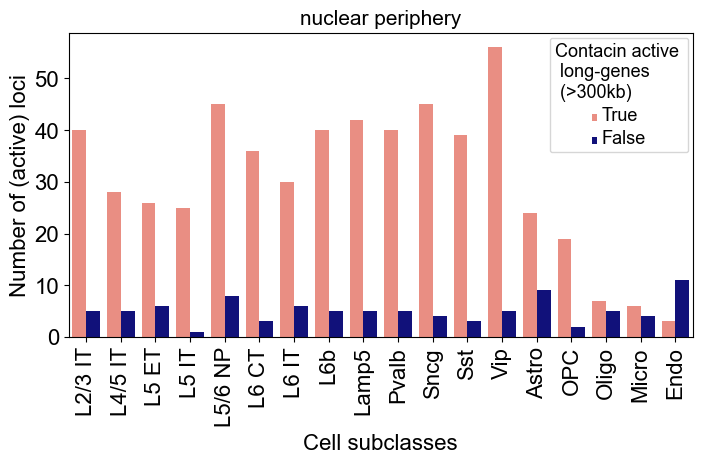

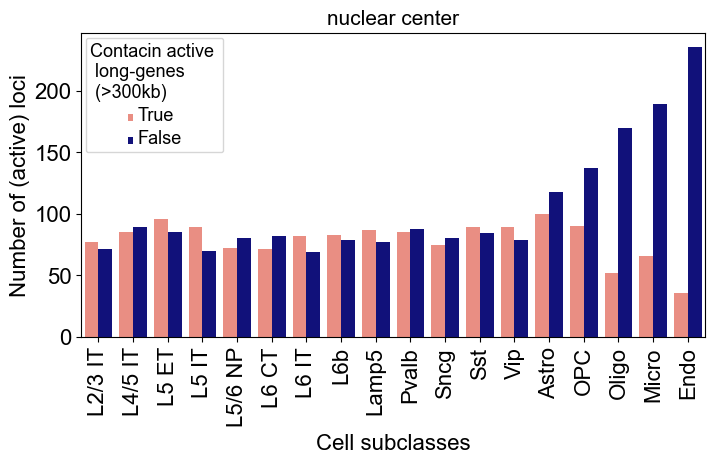

In [608]:
sub_summary_df = summary_df[summary_df['rel_rna_2000kb_activity']=='high']
hue_palette ={True: "salmon", False: "darkblue"}

for _np in ['periphery','center']:
    sel_summary_df = sub_summary_df[sub_summary_df['nuclear_position']==_np]

    fig,ax=plt.subplots(figsize=(8,4),dpi=100)

    gfg = sns.countplot(data=sel_summary_df, x="celltype", 
                  hue=f'abs_active_along_gene_{target_gene_len}kb_loci',
                  hue_order = [True, False],palette = hue_palette
                 )
    ax.grid(False)
    # for legend text
    plt.legend(title=f'Contacin active \n long-genes \n (>{target_gene_len}kb)', #loc='upper center',
               alignment= 'center',
               #labels=['periphery', 'center']
              )
    plt.setp(gfg.get_legend().get_texts(), fontsize='13') 
    # for legend title
    plt.setp(gfg.get_legend().get_title(), fontsize='13') 



    #plt.ylim([0.45,0.99])
    ax.set_ylabel(f"Number of (active) loci", fontsize=16, rotation=90,labelpad=3,)
    ax.set_xlabel(f"Cell subclasses", fontsize=16, rotation=0,labelpad=5,)
    ax.tick_params('both',labelsize=16)
    ax.tick_params('x',rotation=90)
    ax.set_title(f'nuclear {_np}', fontsize=15)
    #plt.ylim([-0.5,3100])
    plt.show()